# Bayesian Optimization 


### Real time control of 2 parallel storm water ponds with bayesian optimization 

In [13]:
# Plotting Libraries and default stuff
import matplotlib.pyplot as plt
%matplotlib notebook
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}
import seaborn as sns
import numpy as np
#sns.set_style("whitegrid")

# Pyswmm engine with ICC 
from pyswmm_lite import Env

# Bayesian Optimization
from GPyOpt.methods import BayesianOptimization
import tslearn.metrics as ts

In [14]:
def run_swmm(valve_set1, valve_set2, flow):
    env = Env("./networks/parallel.inp")

    data = {}
    data["endflow"] = []
    data["overflow1"]  = []
    data["overflow2"]  = []
    done = False
    for time in range(0, len(flow)):
        # set the gate_position 
        env.set_gate("1", valve_set1)
        env.set_gate("2", valve_set2)

        env.sim._model.setNodeInflow("P1", 3*flow[time])
        env.sim._model.setNodeInflow("P2", 3*flow[time])


        # record_data
        data["endflow"].append(env.flow("8"))
        data["overflow1"].append(env.sim._model.getNodeResult("P1", 4))
        data["overflow2"].append(env.sim._model.getNodeResult("P2", 4))

        # step through simulation
        done = env.step()

    return data["endflow"], sum(data["overflow1"]), sum(data["overflow2"])

## Establish the uncontrolled flows in the network

In this scenario, two parallel ponds are draining into a downstream water body.

<IPython.core.display.Javascript object>


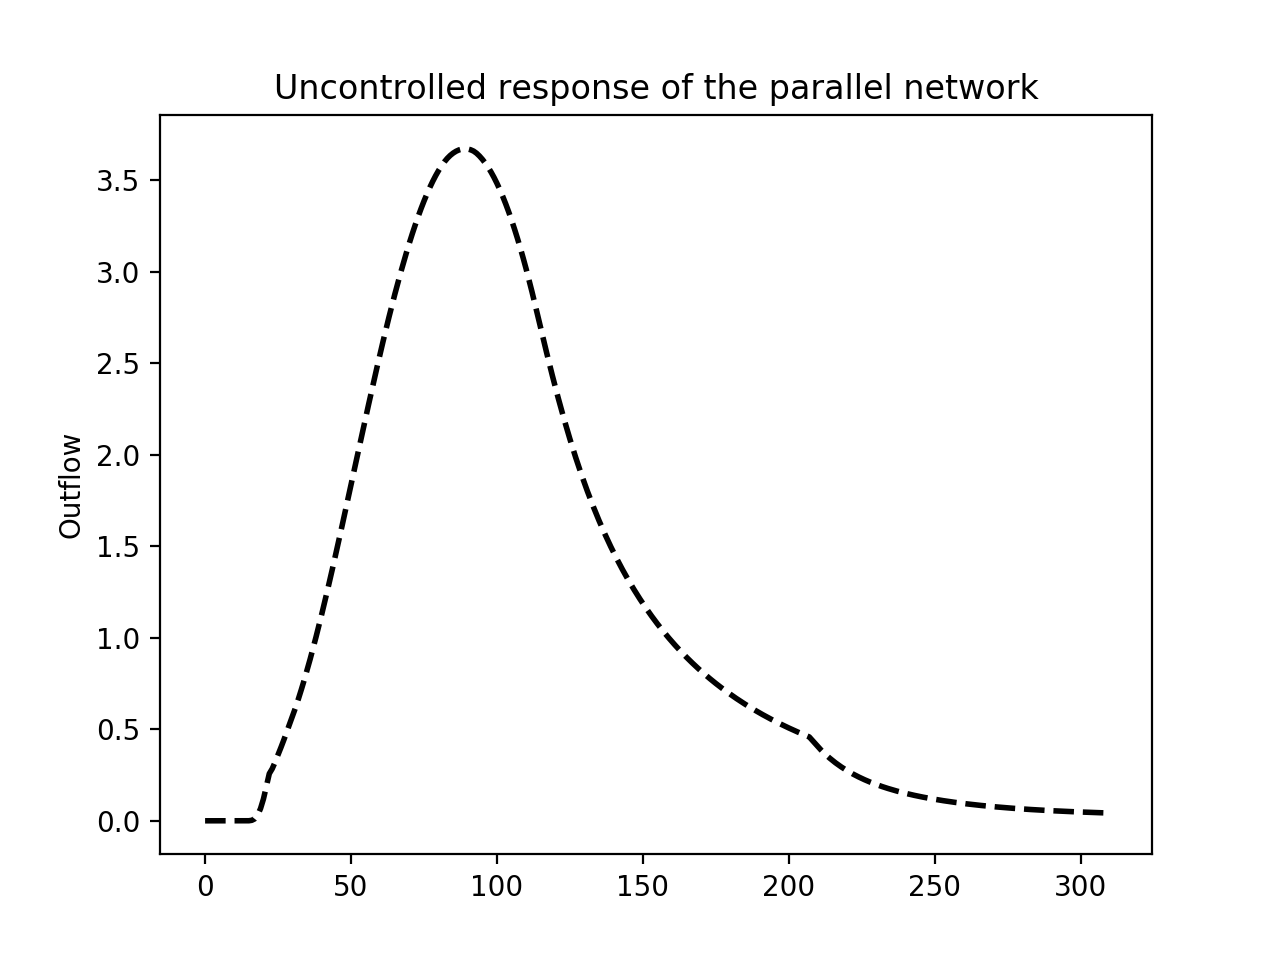

Text(0.5, 1.0, 'Uncontrolled response of the parallel network')

In [16]:
## Let us generate synth flows 
flow = np.sin(np.linspace(0.0, 1.0, 100)*np.pi) # Half sine wave
flow = np.hstack((np.zeros(10), flow, np.zeros(200)))

# Both the ponds in the system receive the same flow 
outflow, _, _ = run_swmm(1.0, 1.0, flow)
# Uncontrolled response 
plt.plot(outflow, "k--", linewidth=2.0)
plt.ylabel("Outflow")
plt.title("Uncontrolled response of the parallel network")

### Target response 

Let us see if we can achive the pre-dev conditions using baysian optimization. For this case study, let us assume that the predev condition is 0.6 of the uncontrolled response.

<IPython.core.display.Javascript object>


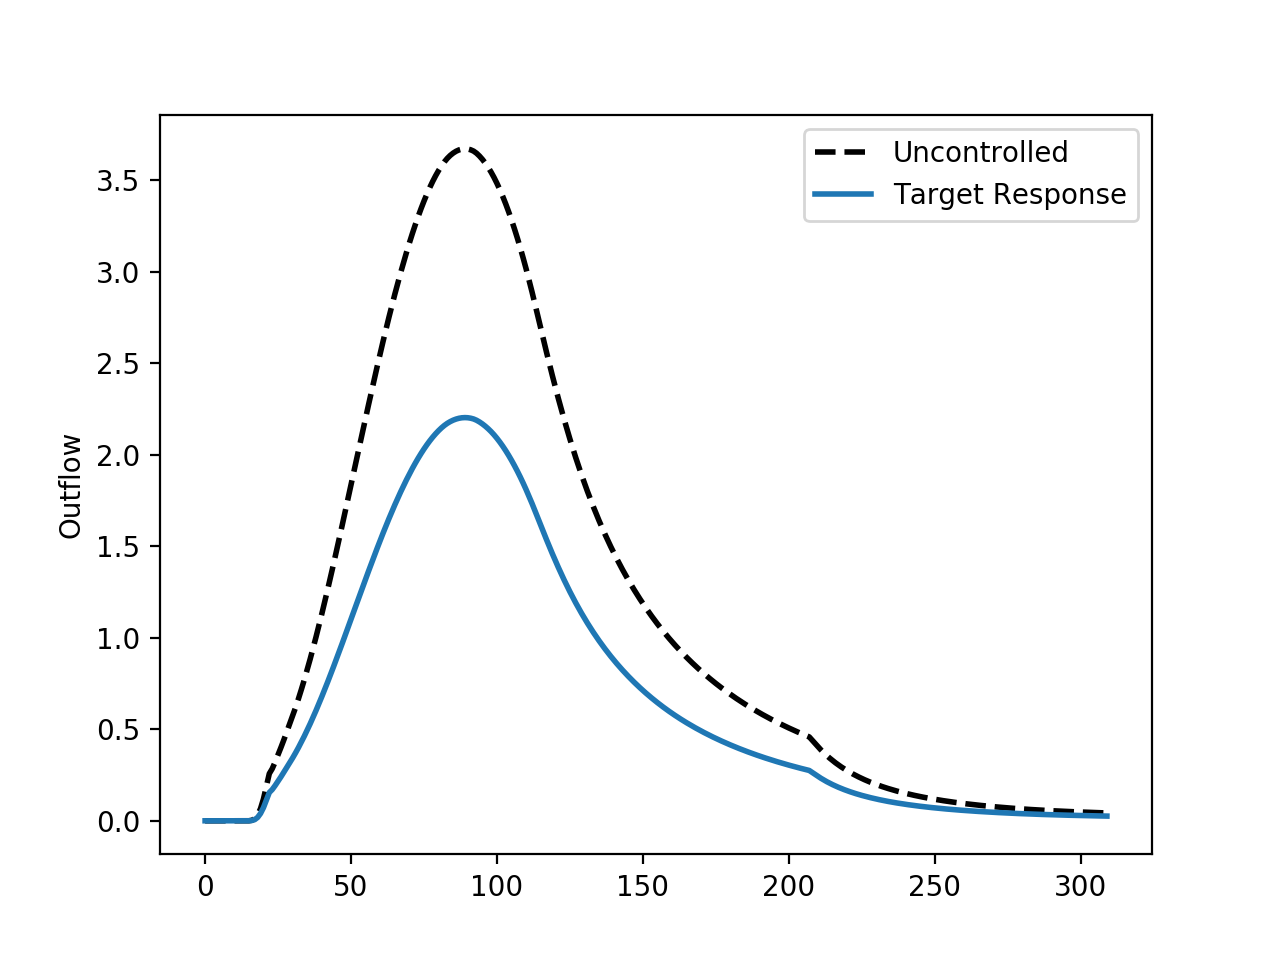

In [17]:
target = np.asarray(outflow)*0.6
plt.plot(outflow, "k--", linewidth=2.0, label="Uncontrolled")
plt.plot(target,  linewidth=2.0, label="Target Response")
plt.ylabel("Outflow")
plt.legend()

<IPython.core.display.Javascript object>


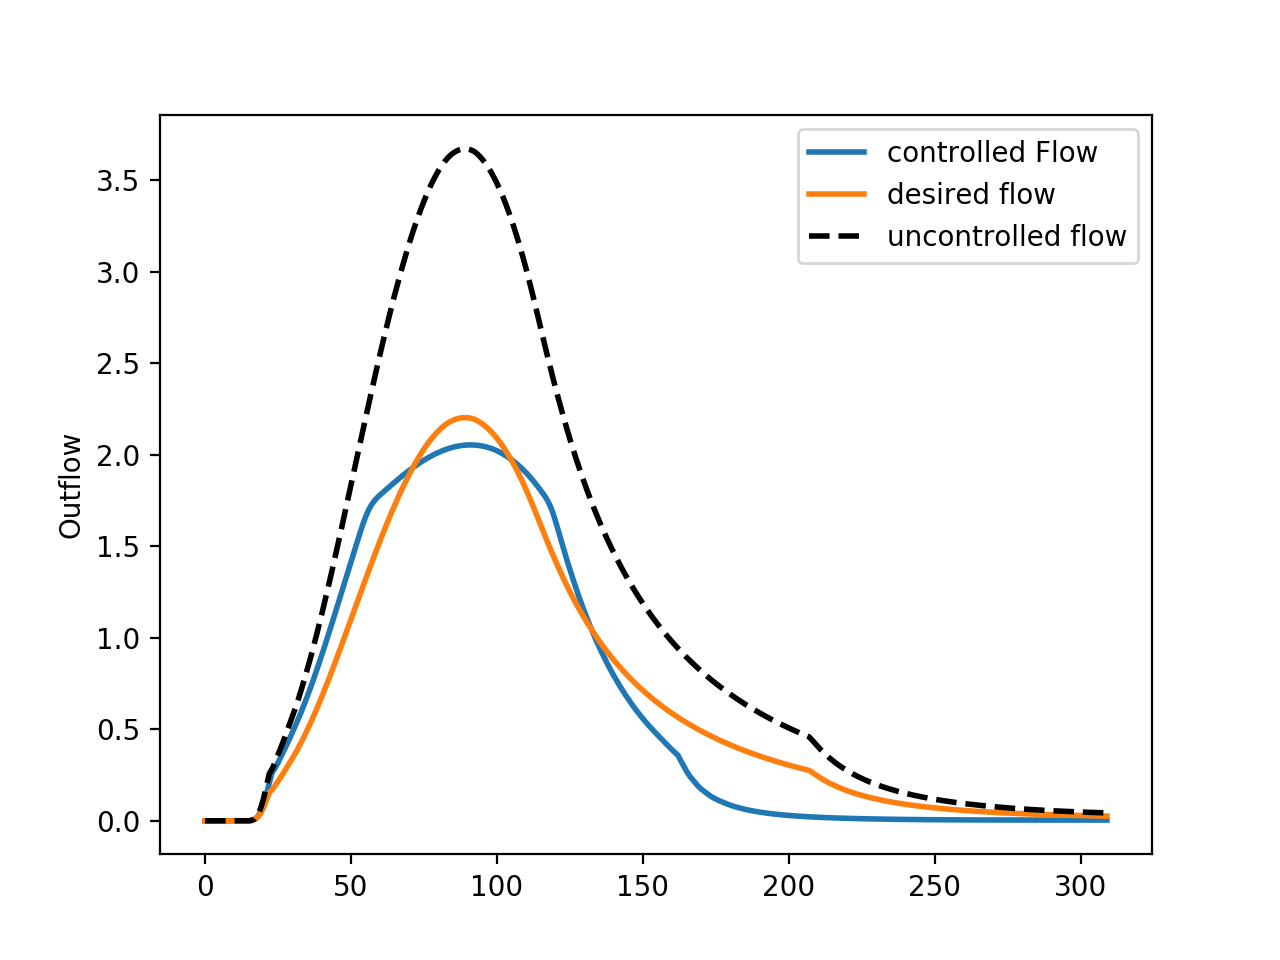

0.0


In [18]:
def fc(x):
    pred_flow, d1, d2 = run_swmm(x[0][0], x[0][1], flow)
    pred_flow = np.asarray(pred_flow)
    path, distance = ts.dtw_path(target, pred_flow)
    loss = distance + (d1 + d2)*10.0
    return loss

# Define gpopt
domain = [{'name': 'var_1', 'type': 'continuous', 'domain': (0.0, 1.0)},
          {'name': 'var_2', 'type': 'continuous', 'domain': (0.0, 1.0)}]

# --- Solve your problem
myBopt = BayesianOptimization(f=fc,
        domain=domain,
        model_type = 'GP',
        acquisition_type='EI',
        exact_feval = True,
        acquisition_weight = 2)

myBopt.run_optimization(max_iter=50)

data_c, ov1, ov2 = run_swmm(myBopt.x_opt[0], myBopt.x_opt[1], flow)

plt.plot(data_c, label = "controlled Flow", linewidth=2.0)
plt.plot(target, label = "desired flow", linewidth=2.0)
plt.plot(outflow, "k--", label = "uncontrolled flow", linewidth=2.0)
plt.ylabel("Outflow")
plt.legend()
print(ov1 + ov2)

Valve settings in this scenario were 0.60138243, 0.0. Which makes sense, let us increase the intensity of inflow to force the controller to use both of the ponds

<IPython.core.display.Javascript object>


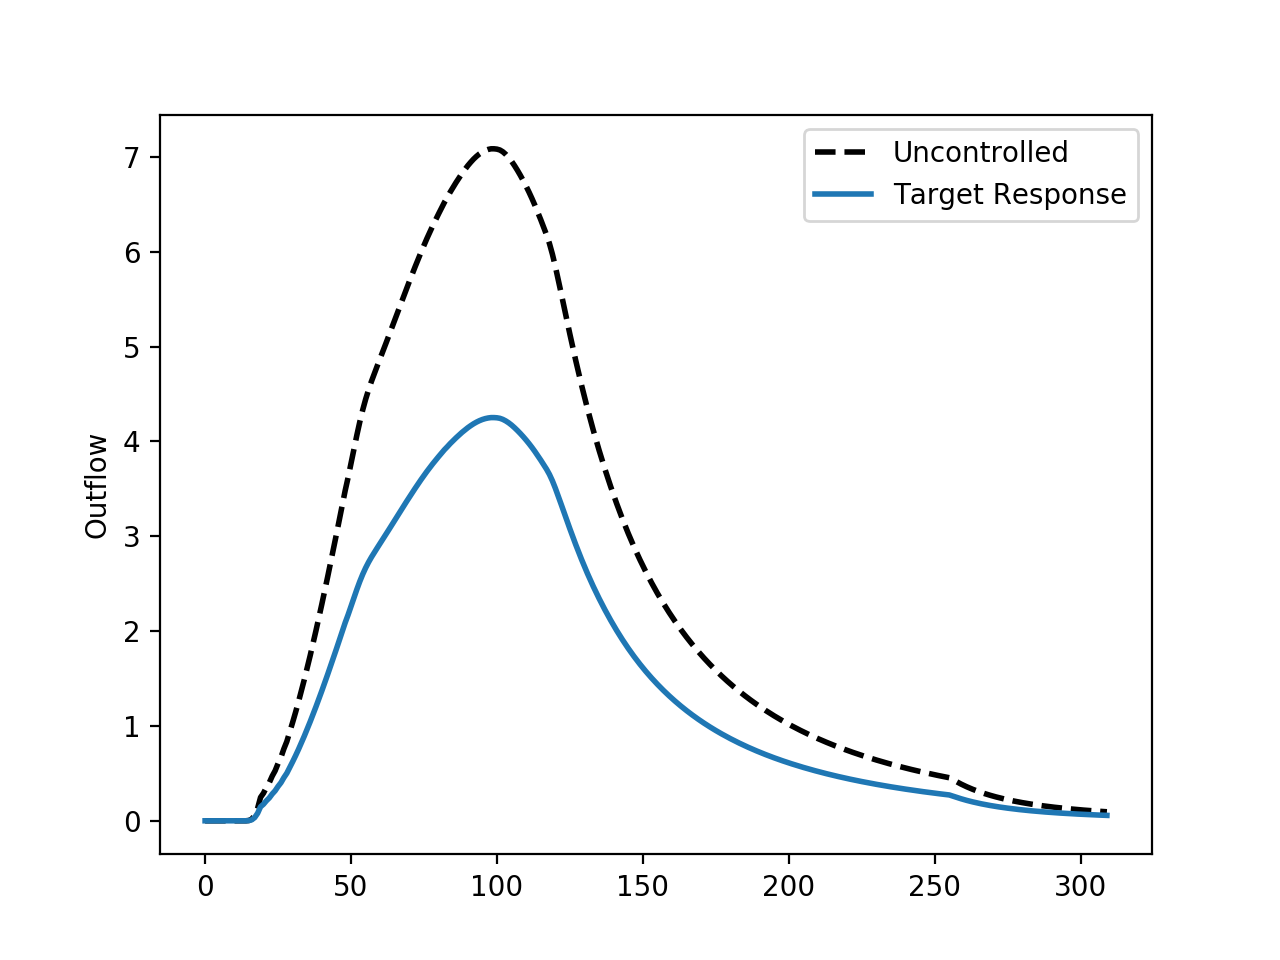

In [27]:
## Let us generate synth flows 
flow = np.sin(np.linspace(0.0, 1.0, 100)*np.pi) * 2.0 # Half sine wave
flow = np.hstack((np.zeros(10), flow, np.zeros(200)))

# Both the ponds in the system receive the same flow 
outflow, _, _ = run_swmm(1.0, 1.0, flow)

target = np.asarray(outflow)*0.6
plt.plot(outflow, "k--", linewidth=2.0, label="Uncontrolled")
plt.plot(target,  linewidth=2.0, label="Target Response")
plt.ylabel("Outflow")
plt.legend()

<IPython.core.display.Javascript object>


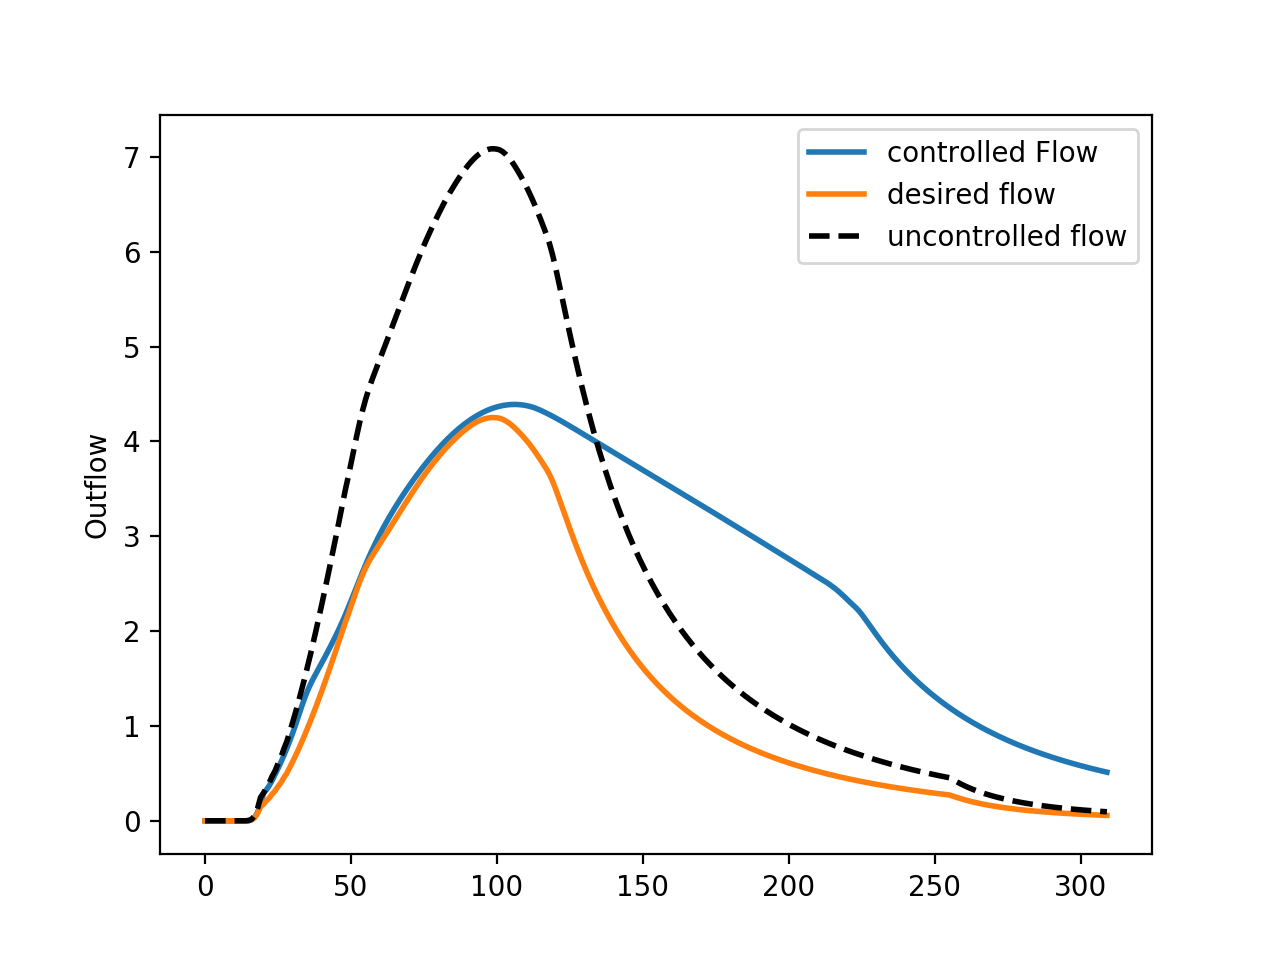

0.0


In [30]:
def fc(x):
    pred_flow, d1, d2 = run_swmm(x[0][0], x[0][1], flow)
    pred_flow = np.asarray(pred_flow)
    path, distance = ts.dtw_path(target, pred_flow)
    loss = distance + (d1 + d2)*10.0
    return loss

# Define gpopt
domain = [{'name': 'var_1', 'type': 'continuous', 'domain': (0.0, 1.0)},
          {'name': 'var_2', 'type': 'continuous', 'domain': (0.0, 1.0)}]

# --- Solve your problem
myBopt = BayesianOptimization(f=fc,
        domain=domain,
        model_type = 'GP',
        acquisition_type='EI',
        exact_feval = True,
        acquisition_weight = 2)

myBopt.run_optimization(max_iter=200)

data_c, ov1, ov2 = run_swmm(myBopt.x_opt[0], myBopt.x_opt[1], flow)

plt.plot(data_c, label = "controlled Flow", linewidth=2.0)
plt.plot(target, label = "desired flow", linewidth=2.0)
plt.plot(outflow, "k--", label = "uncontrolled flow", linewidth=2.0)
plt.ylabel("Outflow")
plt.legend()
print(ov1 + ov2)

Valve settings in this scenario were 0.43650539, 0.42207294. In this scenario, controller is using both the ponds almost equally. Makes sense as both of them are of similar capacity and they take in the same inflow. 

## Comparing the performance of DTW objective function with a ED objective function 

<IPython.core.display.Javascript object>


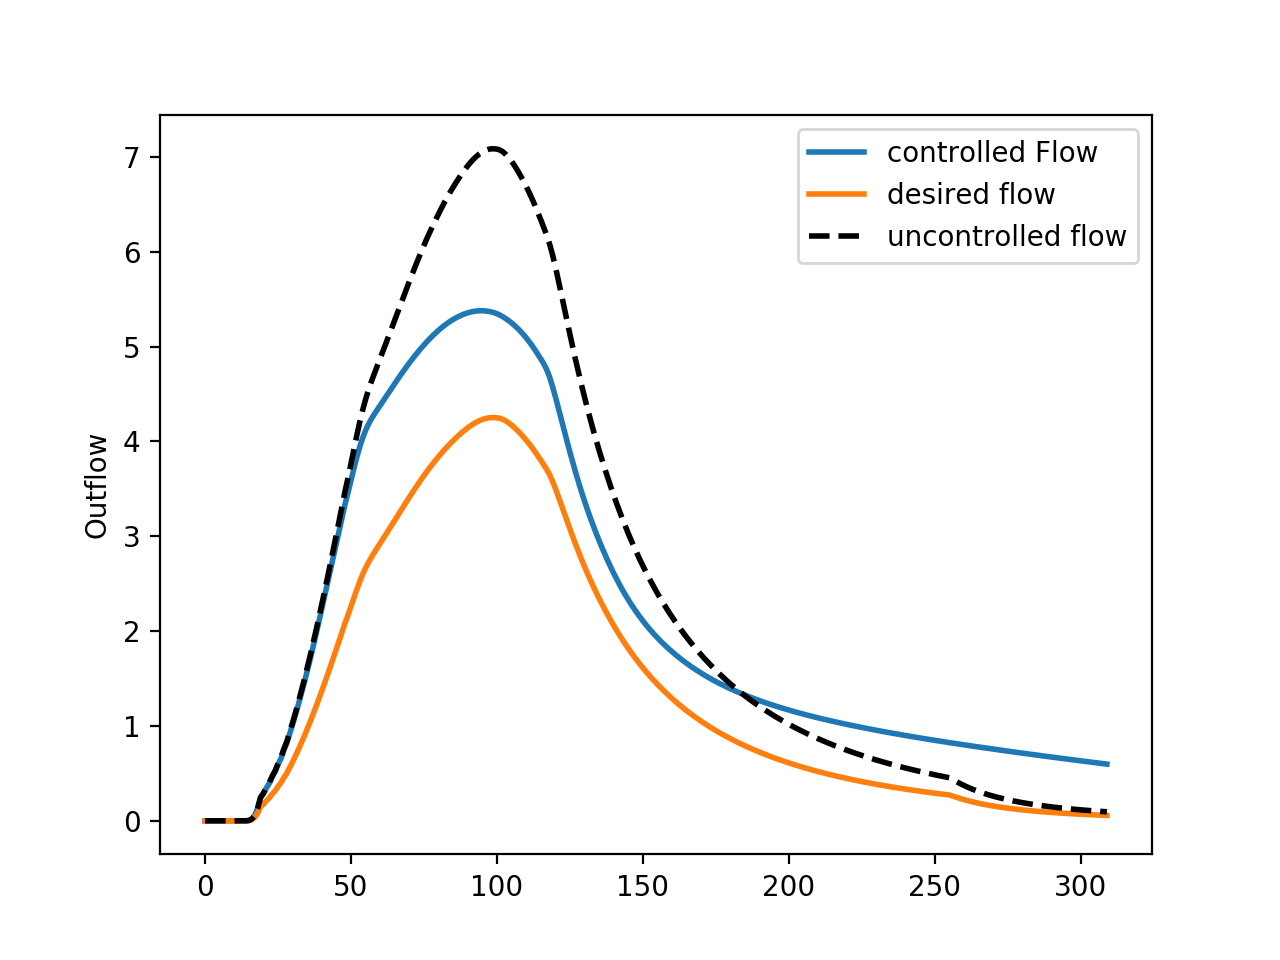

0.0


In [34]:
def fc(x):
    pred_flow, d1, d2 = run_swmm(x[0][0], x[0][1], flow)
    pred_flow = np.asarray(pred_flow)
    distance = np.dot((pred_flow - target).T, (pred_flow - target))
    loss = distance + (d1 + d2)*10.0
    return loss

# Define gpopt
domain = [{'name': 'var_1', 'type': 'continuous', 'domain': (0.0, 1.0)},
          {'name': 'var_2', 'type': 'continuous', 'domain': (0.0, 1.0)}]

# --- Solve your problem
myBopt = BayesianOptimization(f=fc,
        domain=domain,
        model_type = 'GP',
        acquisition_type='EI',
        exact_feval = True,
        acquisition_weight = 2)

myBopt.run_optimization(max_iter=1000)

data_c, ov1, ov2 = run_swmm(myBopt.x_opt[0], myBopt.x_opt[1], flow)

plt.plot(data_c, label = "controlled Flow", linewidth=2.0)
plt.plot(target, label = "desired flow", linewidth=2.0)
plt.plot(outflow, "k--", label = "uncontrolled flow", linewidth=2.0)
plt.ylabel("Outflow")
plt.legend()
print(ov1 + ov2)

The same approach with euclidian distance does not work as well. Even with 5 times more attemps, controller fails to identify a better solution. 